# Amortized methods in geostatistics

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np

import random
from tqdm import tqdm
import time
import os
import torchmin
import joblib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

In [3]:
from scipy.sparse.csgraph import connected_components
from scipy.spatial import cKDTree
from scipy.optimize import minimize
import scipy.linalg as linalg
from scipy.special import gamma, kv

In [4]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
gdoc.setNoScroll()

<IPython.core.display.Javascript object>

## Variables

In [6]:
data_path = "data/test_adv-sep_spatiotemporal_2D"

os.makedirs(data_path, exist_ok=True)
os.makedirs(data_path+"/adv/train/samples", exist_ok=True)
os.makedirs(data_path+"/adv/test/samples", exist_ok=True)
os.makedirs(data_path+"/sep/train/samples", exist_ok=True)
os.makedirs(data_path+"/sep/test/samples", exist_ok=True)

In [7]:
space_size = 30
time_size = 30
deepset_size = 5
missing_ratio = 1/2

train_size = 400 
test_size = 100 

## Utils

In [8]:
def add_missing_mask(batch, missing_ratio):
    nb_missing = int(space_size*missing_ratio)
    missings = np.sort(np.random.permutation(space_size)[:nb_missing])
    batch[:,:,:,missings] = 0
    mask = np.zeros_like(batch)
    mask[:,:,:,missings] = 1
    return np.concatenate([batch, mask], axis=1) 

## Simulation and Load 1

In [9]:
def simulate_matern_grid(time_size, space_size, adv, range_time, range_space, std, deepset_size=5):
    
    model = gl.Model.createFromParam(gl.ECov.MATERN, ranges = [range_time,range_space], param = 1, sill = std**2, flagRange=False)

    shape_adv = abs(adv)+1

    grid = gl.DbGrid.create(
        nx = [time_size,space_size  + time_size*shape_adv],    
        dx = [1./time_size,1./space_size]
    )

    mesh = gl.MeshETurbo(grid)

    pop = gl.PrecisionOpMatrix(mesh, model.getCovAniso(0))

    batch = []
        
    for i in range(deepset_size):
            
        res = pop.simulateOne()
        res = res.reshape((time_size,space_size + time_size*shape_adv), order='F')

        t, s = np.meshgrid(np.arange(time_size), np.arange(space_size), indexing='ij')
        offset = t.copy() * abs(adv)
        s = s + offset


        if adv >= 0 :
            res = res[t,s]
        else :
            res = np.fliplr(res)
            res = res[t,s]
            res = np.fliplr(res)
            
        batch.append(res)

    return np.expand_dims(np.stack(batch),1)

In [10]:
class GridDataset(Dataset):
    def __init__(self, theta_size=200, time_size=40, space_size=40, deepset_size=5, missing_ratio=0):

        self.time_size = time_size
        self.space_size = space_size
        
        self.theta_size = theta_size
        self.deepset_size = deepset_size

        self.adv = np.random.randint(-3,4,(theta_size,)) # np.ones((theta_size,), dtype=int)*-1
        self.range_time = np.random.uniform(0.05,0.25,(theta_size,)) 
        self.range_space = np.random.uniform(0.05,0.25,(theta_size,))
        self.std = np.random.uniform(0.1,1.,(theta_size,))

        self.missing_ratio = missing_ratio

        self.path = None
        self.time_generation = None

    def __len__(self):
        return self.theta_size

    def get_theta(self):
        return torch.from_numpy(np.stack([self.adv,self.range_time, self.range_space, self.std]).T)

    def save(self, path):
        param = {
            "time_size" : self.time_size,
            "space_size" : self.space_size,
            "theta_size" : self.theta_size,
            "deepset_size" : self.deepset_size,
            "missing_ratio" : self.missing_ratio,
            "adv" : self.adv,
            "range_time" : self.range_time,
            "range_space" : self.range_space,
            "std" : self.std,
            "time_generation" : self.time_generation,
        }
        np.save(f"{path}/thetas.npy", param)  
        self.path = path

    @classmethod
    def load(cls, path):

        param = np.load(f"{path}/thetas.npy", allow_pickle=True).item()

        instance = cls(
            theta_size=param["theta_size"],
            time_size=param["time_size"],
            space_size=param["space_size"],
            deepset_size=param["deepset_size"],
            missing_ratio=param["missing_ratio"]
        )

        instance.adv = param["adv"]
        instance.range_time = param["range_time"]
        instance.range_space = param["range_space"]
        instance.std = param["std"]
        instance.time_generation = param.get("time_generation", None)

        instance.path = path

        return instance

    def generate(self, path):

        t = tqdm(range(0, self.theta_size),total=self.theta_size)
        time_generation = time.time()

        for idx in t:

            batch = simulate_matern_grid(
                self.time_size, self.space_size, 
                self.adv[idx], self.range_time[idx], self.range_space[idx],
                self.std[idx],
                self.deepset_size
            )

            np.save(f"{path}/samples/sample_{idx}.npy",batch) 

        self.time_generation = time.time() - time_generation
        
        self.save(path)
    
    def __getitem__(self, idx):

        batch = np.load(f"{self.path}/samples/sample_{idx}.npy")

        if self.missing_ratio > 0 :
            batch = add_missing_mask(batch, self.missing_ratio)

        theta = self.get_theta()[idx].tile(self.deepset_size,1)

        deepset = torch.ones(self.deepset_size, dtype=int) * idx # torch.tensor([i for i in range(self.deepset_size) if not(theta[i] in theta[:i])])

        return (torch.from_numpy(batch), theta, deepset)           

In [11]:
dataset_grid = GridDataset(theta_size=train_size, time_size=time_size, space_size=space_size, deepset_size=deepset_size,missing_ratio=missing_ratio)

dataset_grid.generate(data_path+"/adv/train")

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.99it/s]


Text(0.5, 1.0, 'mask')

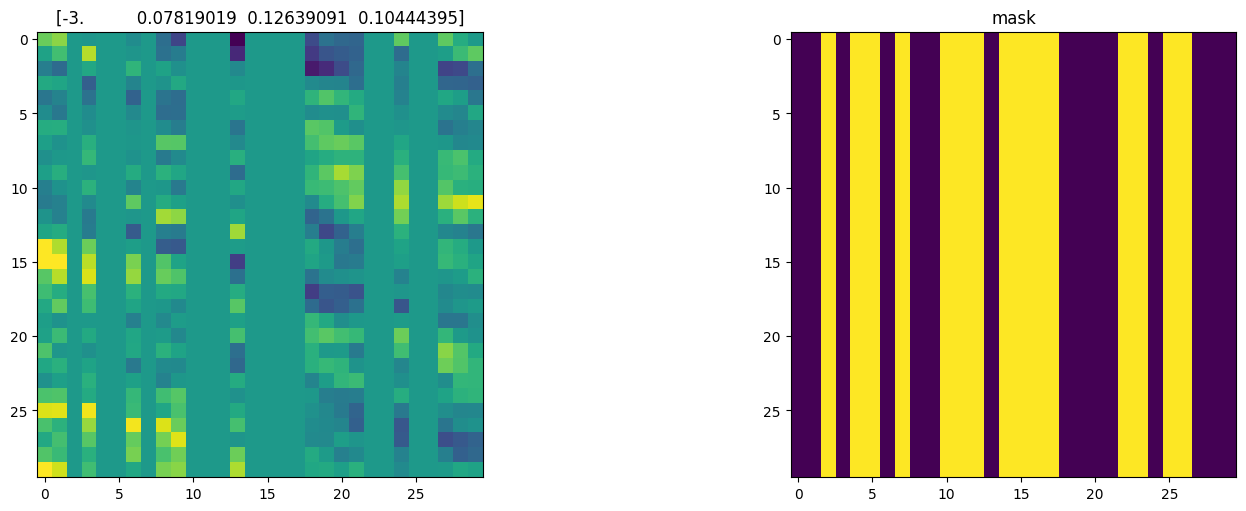

In [13]:
m=0
im = dataset_grid[0]
fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
ax[0].imshow(im[0][m][0], aspect='equal')
ax[0].set_title(im[1][m].detach().numpy())
ax[1].imshow(im[0][m][1], aspect='equal')
ax[1].set_title("mask")

Text(0.5, 1.0, '[1.         0.21752608 0.05202267 0.19839614]')

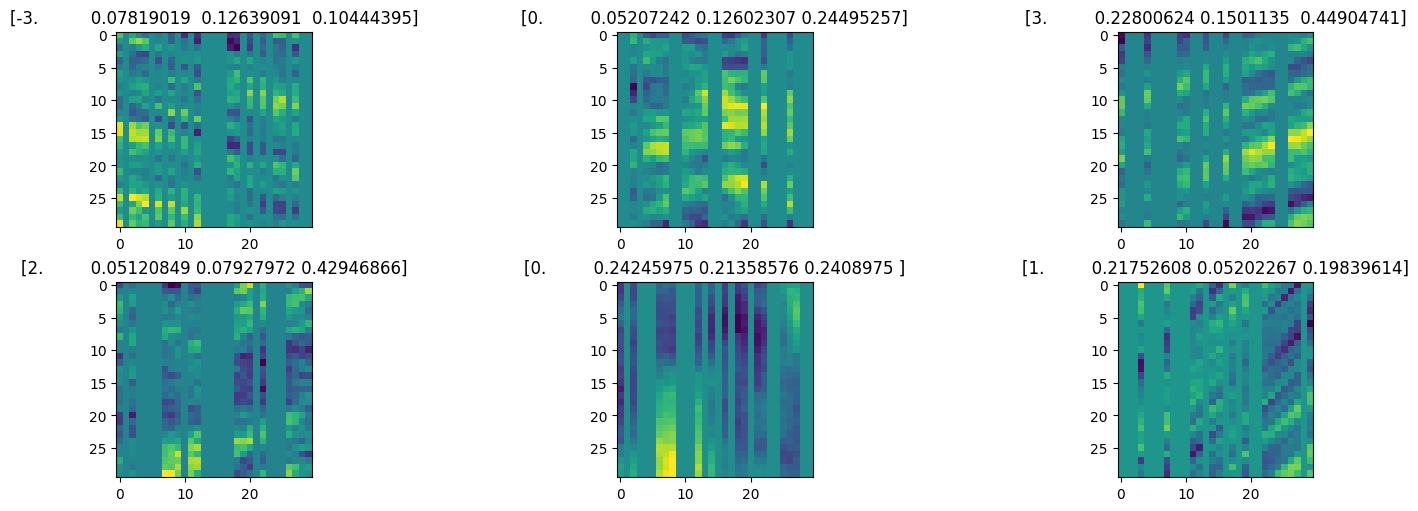

In [14]:
m=0
fig, ax = plt.subplots(2, 3, figsize=(15, 5), constrained_layout=True)
ax[0,0].imshow(dataset_grid[0][0][m][0], aspect='equal')
ax[0,0].set_title(dataset_grid[0][1][m].detach().numpy())
ax[0,1].imshow(dataset_grid[1][0][m][0], aspect='equal')
ax[0,1].set_title(dataset_grid[1][1][m].detach().numpy())
ax[0,2].imshow(dataset_grid[2][0][m][0], aspect='equal')
ax[0,2].set_title(dataset_grid[2][1][m].detach().numpy())
ax[1,0].imshow(dataset_grid[3][0][m][0], aspect='equal')
ax[1,0].set_title(dataset_grid[3][1][m].detach().numpy())
ax[1,1].imshow(dataset_grid[4][0][m][0], aspect='equal')
ax[1,1].set_title(dataset_grid[4][1][m].detach().numpy())
ax[1,2].imshow(dataset_grid[5][0][m][0], aspect='equal')
ax[1,2].set_title(dataset_grid[5][1][m].detach().numpy())

## Simulation and Load 2

In [15]:
def variogram(u, alpha=1.0, b=1.0):
    """Variogram: gamma(u) = (|u|/b)^alpha"""
    return (np.abs(u) / b) ** alpha

def matern_cov(h, nu=1.5, a=1.0):
    """Matern isotropic covariance function"""
    d = np.abs(h)
    res = np.ones_like(d)
    mask = d > 0
    
    if np.any(mask):
        d_val = d[mask]
        const = 2.0 / gamma(nu)
        term = (d_val / (2.0 * a)) ** nu
        bessel = kv(nu, d_val / a)
        res[mask] = const * term * bessel
        
    return res

def sim_w(p, Nt, params):
    """
    Simulates p copies of temporal processes W with temporal variogram 
    gamma*(u) = (gamma(u)+1)^beta - 1
    """
    # Params: [nu, a, alpha, b, beta, delta, k]
    alpha, b_param, beta = params[2], params[3], params[4]

    t_indices = np.arange(1, Nt + 1)
    
    c1 = (variogram(-t_indices, alpha=alpha, b=b_param) + 1.0) ** beta - 1.0
    
    diff_matrix = t_indices[:, None] - t_indices[None, :]
    cc_term = (variogram(diff_matrix, alpha=alpha, b=b_param) + 1.0) ** beta - 1.0
    
    cc = c1[:, None] + c1[None, :] - cc_term
    
    L = np.linalg.cholesky(cc + 1e-10 * np.eye(Nt))
    
    X = np.random.normal(size=(Nt, p))
    
    W = L @ X
    return W.T 

def sim_z1(p, Nt, params):
    """
    Simulates p copies of temporal processes Z1 with temporal covariance function
    gamma*(u) = (gamma(u)+1)^(-delta)
    """
    alpha, b_param, delta = params[2], params[3], params[5]

    t_indices = np.arange(1, Nt + 1)
    diff_matrix = t_indices[:, None] - t_indices[None, :]
    cc = 1.0 / (variogram(diff_matrix, alpha=alpha, b=b_param) + 1.0) ** delta
    
    L = np.linalg.cholesky(cc + 1e-10 * np.eye(Nt))
    X = np.random.normal(size=(Nt, p))
    
    Z = L @ X
    return Z.T # (p, Nt)

def sim_rvs(p, params):
    """
    Simulates all necessary Random Variables for the 
    spectral band simulation algorithm with substitution approach
    """
    nu, a = params[0], params[1]
    k = params[6] 
    
    r_gamma = np.random.gamma(shape=nu, scale=2 * (a**2), size=p)
    
    R_val = 1.0 / (2.0 * r_gamma)
    multR = np.sqrt(2.0 * R_val)
    
    Phi = 2 * np.pi * np.random.uniform(size=p)
    
    U_rand = np.random.uniform(size=p)
    UU = np.sqrt(-2.0 * np.log(U_rand))
    
    Omega = np.random.normal(size=(k, p))
    
    return {
        "UU": UU,       # (p,)
        "multR": multR, # (p,)
        "Omega": Omega, # (k, p)
        "Phi": Phi      # (p,)
    }

def ztilde_t_vecs(s, t_idx, rvs, W, Z1, sigma):
    """
    Do the computation of the simulated RF
    s: coordinates (Ns, k)
    t_idx: time (0 to Nt-1)
    """
    UU = rvs["UU"]       
    multR = rvs["multR"] 
    Omega = rvs["Omega"] 
    Phi = rvs["Phi"]     
    
    nOmega = np.linalg.norm(Omega, axis=0) # (p,)
    
    ww_t = W[:, t_idx]   # (p,)
    zz_t = Z1[:, t_idx]  # (p,)
    
    p = len(UU)
    
    spatial_proj = s @ Omega 
    term_cos = (spatial_proj * multR) + (nOmega * ww_t / np.sqrt(2)) + Phi
    V = np.cos(term_cos)
    
    V = V * UU * zz_t
    
    field_t = np.sum(V, axis=1) / np.sqrt(p)
    
    return field_t * sigma

def simulate_spatio_temporal(params_dict, Nt, s_coords):
    k = 1
    p = 3000 
    
    nu = params_dict['smooth_s']
    a = params_dict['scale_s']
    alpha = params_dict['power_t']
    b = params_dict['scale_t']
    bet = params_dict['sep']
    
    delta = params_dict['power2_t'] - bet
    
    sim_params = [nu, a, alpha, b, bet, delta, k]
    
    sigma = np.sqrt(params_dict['sill'])
    
    t0 = time.time()
    W = sim_w(p, Nt, sim_params)   # (p, Nt)
    Z1 = sim_z1(p, Nt, sim_params) # (p, Nt)
    RVs = sim_rvs(p, sim_params)
    
    Ns = s_coords.shape[0]
    Z_field = np.zeros((Ns, Nt))
    
    # Loop on time (space in vectorized)
    for t in range(Nt):
        Z_field[:, t] = ztilde_t_vecs(s_coords, t, RVs, W, Z1, sigma)
            
    return Z_field

In [17]:
class SepDataset(Dataset):
    def __init__(self, theta_size=200, time_size=40, space_size=40, deepset_size=5, missing_ratio=0):

        self.time_size = time_size
        self.space_size = space_size
        
        self.theta_size = theta_size
        self.deepset_size = deepset_size

        self.sep = np.log10(np.random.uniform(1.,2.,(theta_size,)))
        self.scale_time = np.random.uniform(1.,10.,(theta_size,)) 
        self.scale_space = np.random.uniform(1.,10.,(theta_size,))
        self.sill = np.random.uniform(.1,1.,(theta_size,))            # np.ones((theta_size,), dtype=int)*-1

        self.missing_ratio = missing_ratio

        self.path = None
        self.time_generation = None

    def __len__(self):
        return self.theta_size

    def get_theta(self):
        return torch.from_numpy(np.stack([self.sep,self.scale_time, self.scale_space, self.sill]).T)

    def save(self, path):
        param = {
            "time_size" : self.time_size,
            "space_size" : self.space_size,
            "theta_size" : self.theta_size,
            "deepset_size" : self.deepset_size,
            "missing_ratio" : self.missing_ratio,
            "sill" : self.sill,
            "scale_time" : self.scale_time,
            "scale_space" : self.scale_space,
            "sep" : self.sep,
            "time_generation" : self.time_generation,
        }
        np.save(f"{path}/thetas.npy", param)  
        self.path = path

    @classmethod
    def load(cls, path):

        param = np.load(f"{path}/thetas.npy", allow_pickle=True).item()

        instance = cls(
            theta_size=param["theta_size"],
            time_size=param["time_size"],
            space_size=param["space_size"],
            deepset_size=param["deepset_size"],
            missing_ratio=param["missing_ratio"]
        )

        instance.adv = param["sill"]
        instance.range_time = param["scale_time"]
        instance.range_space = param["scale_space"]
        instance.std = param["sep"]
        instance.time_generation = param.get("time_generation", None)

        instance.path = path

        return instance

    def generate(self, path):

        t = tqdm(range(0, self.theta_size),total=self.theta_size)
        time_generation = time.time()

        s = np.expand_dims(np.arange(1, self.space_size + 1),1)

        for idx in t:

            batch = []
            for i in range(self.deepset_size):
    
                params = {
                    'mean': 0,
                    'sill': self.sill[idx],       
                    'smooth_s': 1.0,   
                    'scale_s': self.scale_space[idx],    
                    'power_t': 0.5,    
                    'scale_t': self.scale_time[idx],     
                    'sep': self.sep[idx],        
                    'power2_t': self.sep[idx]*2
                }
                
                batch.append(simulate_spatio_temporal(params, self.time_size, s).T)
            batch = np.expand_dims(np.stack(batch), 1)

            np.save(f"{path}/samples/sample_{idx}.npy",batch) 

        self.time_generation = time.time() - time_generation
        
        self.save(path)

    
    def __getitem__(self, idx):

        batch = np.load(f"{self.path}/samples/sample_{idx}.npy")

        if self.missing_ratio > 0 :
            batch = add_missing_mask(batch, self.missing_ratio)

        theta = self.get_theta()[idx].tile(self.deepset_size,1)

        deepset = torch.ones(self.deepset_size, dtype=int) * idx # torch.tensor([i for i in range(self.deepset_size) if not(theta[i] in theta[:i])])

        return (torch.from_numpy(batch), theta, deepset)           

In [18]:
dataset_sep = SepDataset(theta_size=train_size, time_size=time_size, space_size=space_size, deepset_size=deepset_size,missing_ratio=missing_ratio)
dataset_sep.generate(data_path+"/sep/train")

100%|████████████████████████████████████████████████████████████████████| 400/400 [04:56<00:00,  1.35it/s]


Text(0.5, 1.0, 'mask')

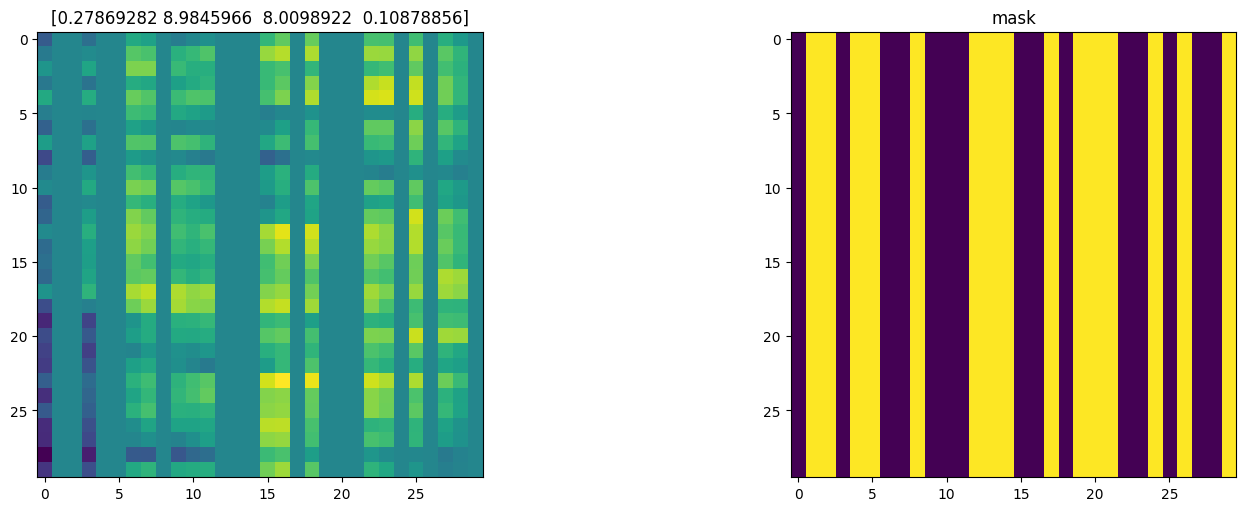

In [19]:
m=0
im = dataset_sep[0]
fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
ax[0].imshow(im[0][m][0], aspect='equal')
ax[0].set_title(im[1][m].detach().numpy())
ax[1].imshow(im[0][m][1], aspect='equal')
ax[1].set_title("mask")

Text(0.5, 1.0, '[0.14179866 5.87999511 9.62373135 0.2989374 ]')

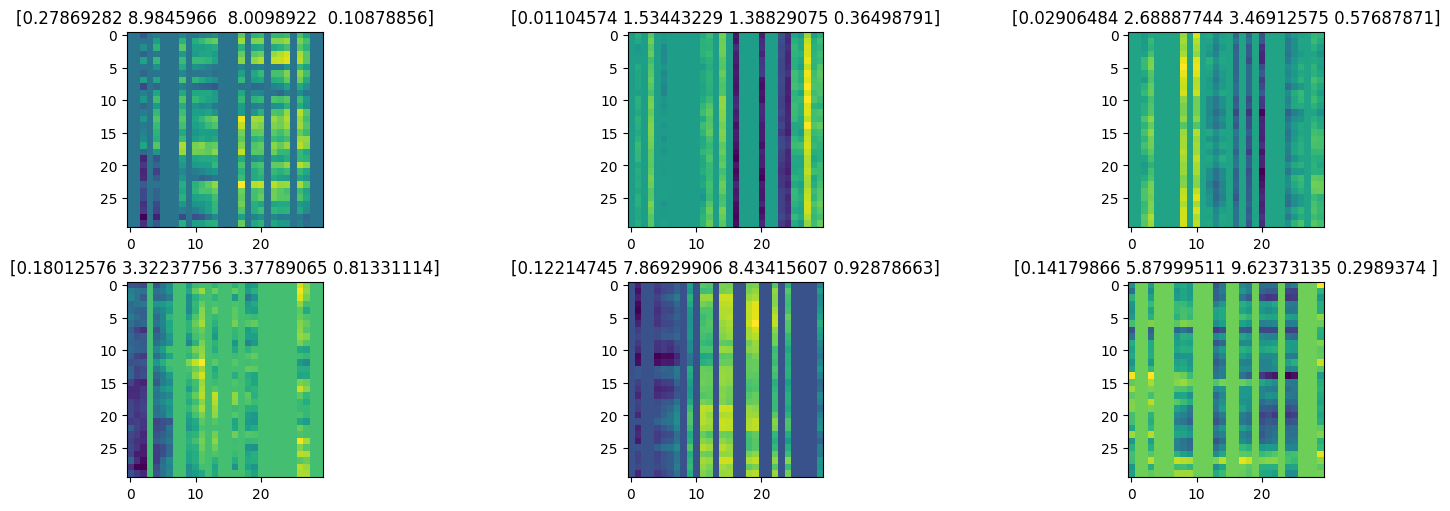

In [20]:
m=0
fig, ax = plt.subplots(2, 3, figsize=(15, 5), constrained_layout=True)
ax[0,0].imshow(dataset_sep[0][0][m][0], aspect='equal')
ax[0,0].set_title(dataset_sep[0][1][m].detach().numpy())
ax[0,1].imshow(dataset_sep[1][0][m][0], aspect='equal')
ax[0,1].set_title(dataset_sep[1][1][m].detach().numpy())
ax[0,2].imshow(dataset_sep[2][0][m][0], aspect='equal')
ax[0,2].set_title(dataset_sep[2][1][m].detach().numpy())
ax[1,0].imshow(dataset_sep[3][0][m][0], aspect='equal')
ax[1,0].set_title(dataset_sep[3][1][m].detach().numpy())
ax[1,1].imshow(dataset_sep[4][0][m][0], aspect='equal')
ax[1,1].set_title(dataset_sep[4][1][m].detach().numpy())
ax[1,2].imshow(dataset_sep[5][0][m][0], aspect='equal')
ax[1,2].set_title(dataset_sep[5][1][m].detach().numpy())